# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [3]:
display(data.head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


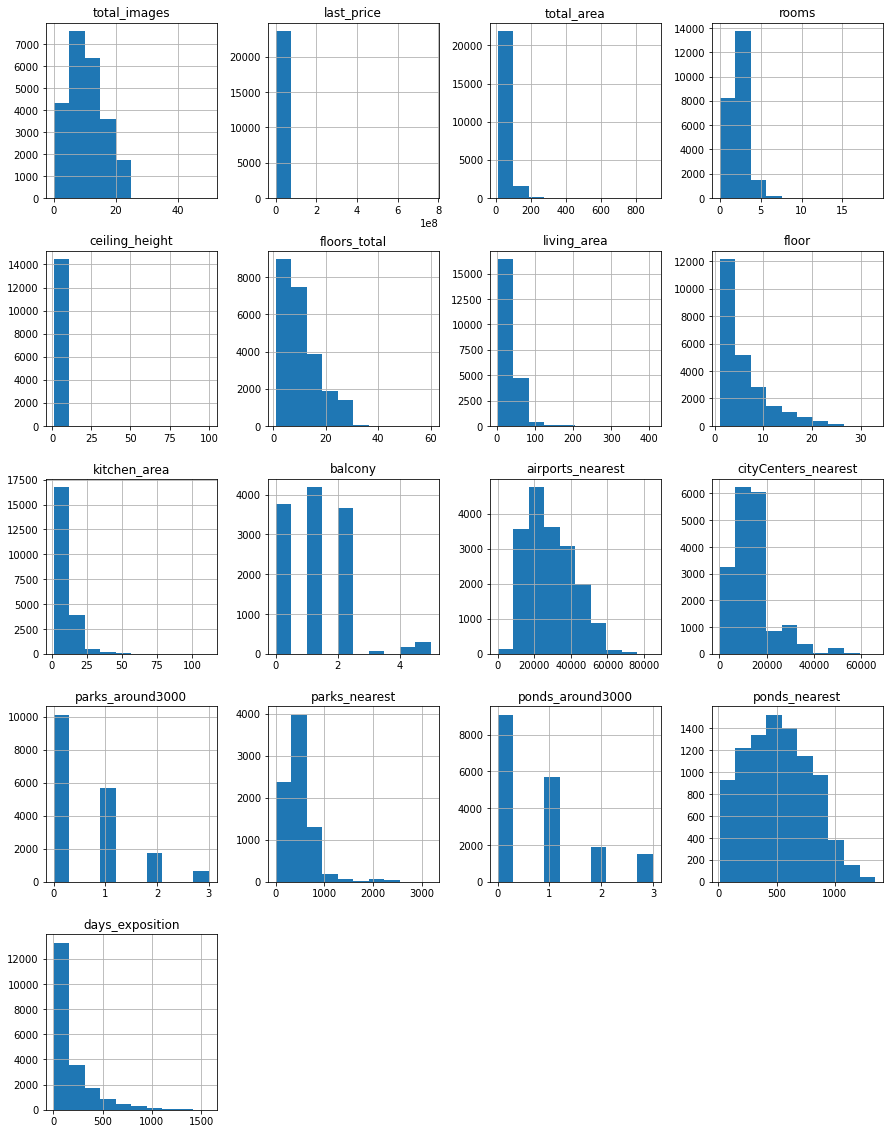

In [4]:
data.hist(figsize=(15, 20));
pd.set_option('display.max_columns', None)

по количеству пропусков кажется, что данных было утраченно уж очень много (вон в info с первых строк уже есть пропуски), но не стоит делать поспешных выводов, возможно, большинство из них получится заполнить без серьёзных изменений в дальнейших проверках/исследованиях или их отсутствие не окажется критичным

на первый взгляд можно сказать, что аномальные значения имеются в столбцах про потолки и цены квартир

также интересно почему у балконов тип данных float, вряд ли существуют квартиры с половиной балкона

### Предобработка данных

In [5]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

начнём с простых пропусков, где по логике просто нет этого объекта (балкона, парка, водоёма или не являются апартаментами) и поэтому стоит "пустота"

логично, что если нет парка иль водоёма, то и расстояние до него посчитать нельзя. расстояние до аэропорта и центра вычислить тоже не получится, так как вручную самому искать где находятся 5 тысяч квартир и заполнять пропуска — пагубное дело

расстояние до парка, водоёма, аэропорта и центра просто неизвестно, поэтому пропуски не стоит трогать

пропуски в days_exposition, думаю, вообще не стоит трогать, так как уж сликшом много факторов влияют на эти значения от этажа до количества парков

название населенного пункта узнать не получится, поэтому просто заполним "неизвестно"

отсутствие этажа, конечно, проблема, но избавляться от почти 100 квартир из-за этого не стоит, они ещё могут помочь в дальнейших исследованиях

In [6]:
#data['balcony'] = data['balcony'].fillna(0)
data = data.fillna({'is_apartment':0, 'balcony':0, 'ponds_around3000':0, 'parks_around3000':0})
data['locality_name'] = data['locality_name'].fillna('неизвестно')

апартаменты по условию имеют булевый тип, а количество балконов, этажей, парков и водоёмов не может быть половинчатым

In [7]:
#data['is_apartment'] = data['is_apartment'].astype('bool')
data = data.astype({'is_apartment':'bool', 'balcony':'int64', 'ponds_around3000':'int64', 'parks_around3000':'int64'})
data['floors_total'] = pd.array(data['floors_total'], dtype=pd.Int64Dtype())

чаще всего жилая площадь и кухня зависят от количества комнат, поэтому пропуски в этих столбцах заполняем медианой по соответсвующим критериям

*конечно, существуют однушки с кухней в 40 квадратных метров, но это скорее исключение, чем норма)*

In [8]:
live = data.groupby('rooms')['living_area'].median()
for j in live.index.to_list():
    data.loc[data['rooms'] == j,'living_area'] = \
    data.loc[data['rooms'] == j,'living_area'].fillna(live[j])

In [9]:
food = data.groupby('rooms')['kitchen_area'].median()
for j in food.index.to_list():
    data.loc[data['rooms'] == j,'kitchen_area'] = \
    data.loc[data['rooms'] == j,'kitchen_area'].fillna(food[j])

прежде чем заполнять высоту потолков, стоит убрать в этом столбце значение потолков равное 10, 10.3 и 14 (это половина длины товарного вагона), а также 1 (это рост ребенка 4-5 лет), и значения больше 19 поделить на 10, чтоб получить метровые значения

заполнять будем медианой, так как есть слишком большой разброс по данным (такая же логика была с размеров жилой площади и кухни)

In [10]:
data['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

In [11]:
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height']<19, data['ceiling_height']/10)
data.drop([22869, 22309, 15061, 22590], axis=0, inplace=True)

In [12]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

#### Избавление от аномалий в столбцах 'rooms', 'last_price', 'total_area'

теперь проверим на аномалии другие столбцы

In [13]:
data['rooms'].unique()

array([ 3,  1,  2,  4,  5,  6,  0,  7, 11,  8, 14, 10, 15,  9, 19, 16, 12])

квартира с нулями комнат? звучит странно, но если на них посмотреть то можно предположить, что это квартиры с одной комнатой

ещё стоит избавится от черезмерно большого количества комнат

In [14]:
data.loc[data['rooms']==0, 'rooms'] = 1
data.drop(data[data['rooms']>7].index, inplace=True)

квартира за 763 миллиона и 12 тысяч, что ты выберешь?

придётся убрать аномально большие и аномально меленькие значение, всё что меньше 2 миллионов и всё что больше 40 миллионов придётся искоренить

In [15]:
data['last_price'].sort_values()

8793         12190.0
17456       430000.0
14911       430000.0
16274       440000.0
17676       450000.0
            ...     
22831    289238400.0
15651    300000000.0
1436     330000000.0
14706    401300000.0
12971    763000000.0
Name: last_price, Length: 23664, dtype: float64

In [16]:
data.drop(data[data['last_price']>40000001].index, inplace=True)
data.drop(data[data['last_price']<2000001].index, inplace=True)

квартиры больше 300 кв.метров являются аномальными значениями

In [17]:
data['total_area'].sort_values()

19904     12.00
19807     13.00
8886      15.50
9412      16.00
22356     17.20
          ...  
5873     400.00
22131    422.20
3676     441.98
20273    460.80
6221     470.30
Name: total_area, Length: 22038, dtype: float64

In [18]:
data.drop(data[data['total_area']>300].index, inplace=True)

#### Выявление неявных дубликатов в слобце 'locality_name'

а теперь пора приступить к выявлению неявных дубликатов и избавлению от них

посёлок и в Африке посёлок

In [19]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'Гатчина', 'поселок Мурино', 'деревня Фёдоровское', 'Выборг',
       'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'посёлок Металлострой', 'посёлок городского типа Сиверский',
       'поселок Молодцово', 'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'посёлок Плодовое', 'деревня Заклинье', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'деревня Старая',
       'деревня Лесколово', 'посёлок Новый Свет', 'село Путилово',
       'Мурино', 'Ивангород', 'Шлиссельбург', 'Никольское', 'Зеленогорск',
       'Сосновый Бор', 'поселок Новый Свет', 'деревня 

In [20]:
duple = ['городской посёлок', 'городской поселок', 'поселок городского типа', 'посёлок городского типа', 'поселок', 'коттеджный посёлок']
data['locality_name'] = data['locality_name'].replace(duple, 'посёлок', regex=True)

### Посчитайте и добавьте в таблицу новые столбцы

начнём со создания столбца с ценной одного квадратного метра ('one_metr')

In [21]:
data['one_metr'] = round(data['last_price']/data['total_area'])

теперь день недели публикации('day')

In [22]:
data['day'] = pd.DatetimeIndex(data['first_day_exposition']).weekday

а тут месяц публикации ('month')

In [23]:
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month

и год ('year'), и этажи ('floor_numder'), и расстояние до центра в киллометрах ('city_center_km')

In [24]:
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

In [25]:
def floor_type(row):
    floor = row['floor']
    floors_total = row['floors_total']
    try:
        if floor == 1:
            return 'первый'
        elif floor == floors_total:
            return 'последний'
    except:
        return 'другой'
    
data['floor_numder'] = data.apply(floor_type, axis=1)
data.loc[(data['floor_numder']!='последний')&(data['floor_numder']!='первый'), 'floor_numder'] = 'другой'

In [26]:
data['city_center_km'] = round(data['cityCenters_nearest']/1000)

### Проведите исследовательский анализ данных

#### Изучите следующие параметры объектов:

    ● квартир с общей площадью примерно 45-50 больше всего на рынке

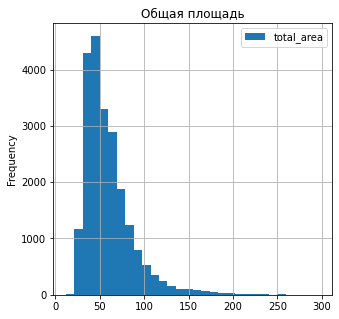

In [27]:
data['total_area'].plot(kind='hist', grid=True, bins=30, figsize=(5, 5), legend=True, title='Общая площадь');

    ● квартиры с жилой площадью 25-30 преобладают на рынке

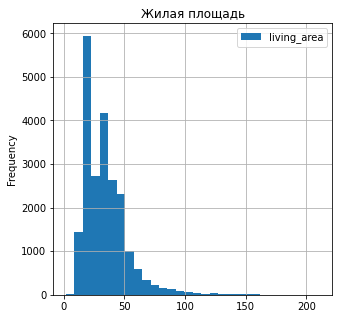

In [28]:
data['living_area'].plot(kind='hist', grid=True, bins=30, figsize=(5, 5), legend=True, title='Жилая площадь');

    ● а вот кухни площадью 8-10 явно встречаются во многих квартирах

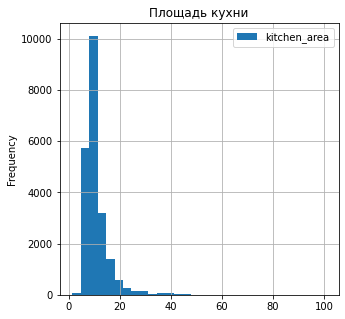

In [29]:
data['kitchen_area'].plot(kind='hist', grid=True, bins=30, figsize=(5, 5), legend=True, title='Площадь кухни');

    ● чаще всего продаются квартиры с ценником от 3.5 до 5 миллионов

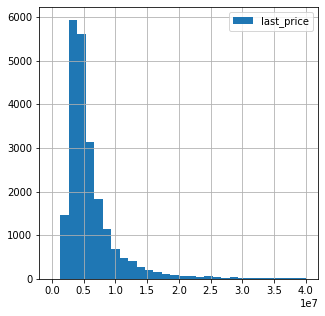

In [30]:
data['last_price'].hist(bins=30, figsize=(5, 5), legend=True, range=(0,40000000));

    ● однушки являются самыми часто встречаемыми, но двушки их догоняют, всего какая-то пара сотен квартир осталась)

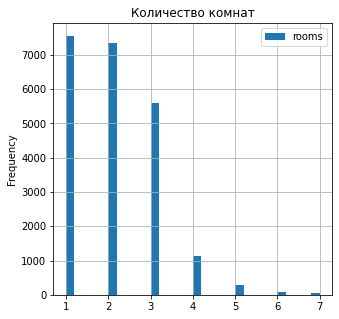

In [31]:
data['rooms'].plot(kind='hist', grid=True, bins=30, figsize=(5, 5), legend=True, title='Количество комнат');

    ● а вот потолки в где-то 2,5 метров не обгонит никто

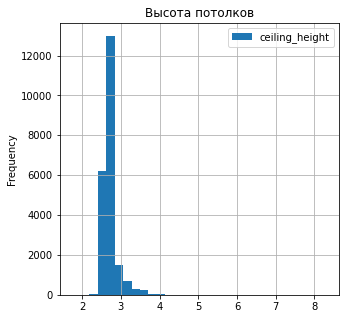

In [32]:
data['ceiling_height'].plot(kind='hist', grid=True, bins=30, figsize=(5, 5), legend=True, title='Высота потолков');

    ● первый этаж самый частый, говорят, он ещё бывает и самый дешевый

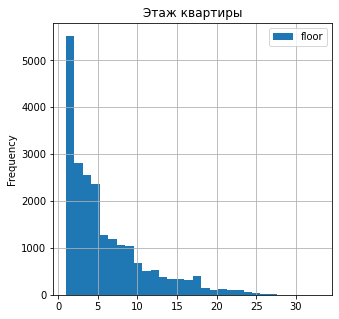

In [33]:
data['floor'].plot(kind='hist', grid=True, bins=30, figsize=(5, 5), legend=True, title='Этаж квартиры');

    ● в целом ожидаемо, что "другие" этажи преобладают

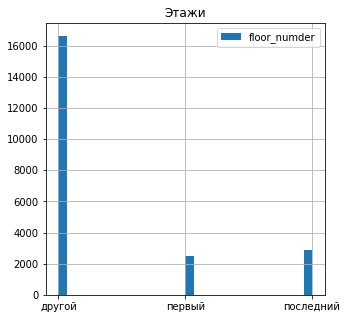

In [34]:
a = data['floor_numder'].hist(bins=30, figsize=(5, 5), legend=True)
a.set_title('Этажи');

    ● похоже квартиры в домиках с 5-6 этажами самые частые

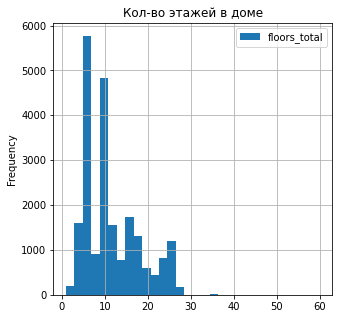

In [35]:
data['floors_total'].plot(kind='hist', grid=True, bins=30, figsize=(5, 5), legend=True, title='Кол-во этажей в доме');

    ● чаще всего квартиры находят от центра в 12-13 км, звучит очень даже близко

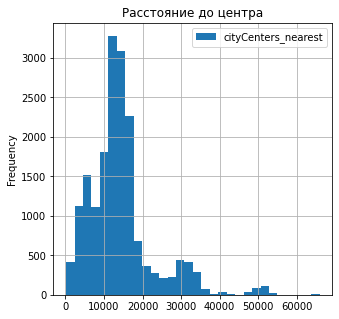

In [36]:
data['cityCenters_nearest'].plot(kind='hist', grid=True, bins=30, figsize=(5, 5), legend=True, title='Расстояние до центра');

    ● а вот до аэропорта придётся ехать чаще всего от 21 км

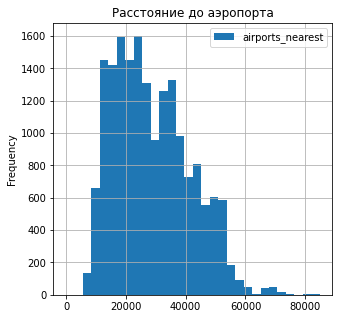

In [37]:
data['airports_nearest'].plot(kind='hist', grid=True, bins=30, figsize=(5, 5), legend=True, title='Расстояние до аэропорта');

    ● многим квартирам повезло с близостью к паркам, всего-то нужно пройти 500 метров

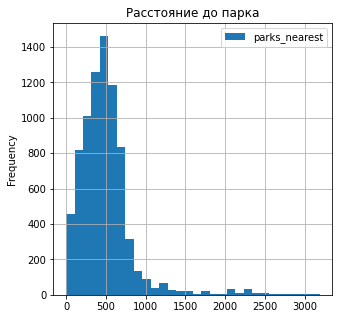

In [38]:
data['parks_nearest'].plot(kind='hist', grid=True, bins=30, figsize=(5, 5), legend=True, title='Расстояние до парка');

    ● чаще всего объявление выкладывают в четверг, а вот реже всего в воскресенье

    рост объявлений приходится на январь, а самый большой спад в мае

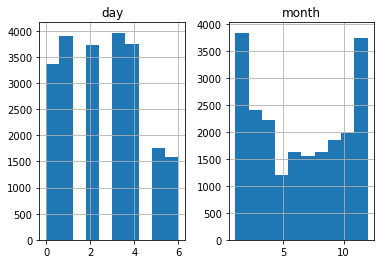

In [39]:
data.loc[:, 'day':'month'].hist();

среднее: 180 медиана: 95.0
мин.значение: 1  макс.значение: 1580.0


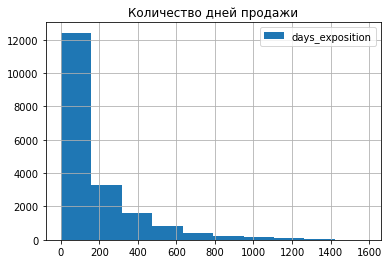

In [40]:
df = data['days_exposition'].hist(legend=True)
df.set_title('Количество дней продажи');
print("среднее:" ,round(data['days_exposition'].mean()),"медиана:", data['days_exposition'].median())
print("мин.значение:" ,round(data['days_exposition'].min())," макс.значение:", data['days_exposition'].max())

#### Какие факторы больше всего влияют на полную стоимость объекта?
##### Зависимость от площадей 

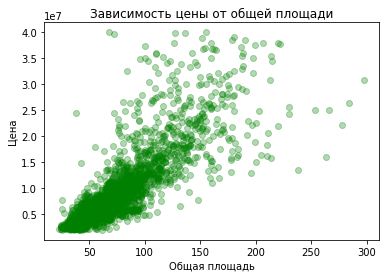

In [41]:
piv_price = data.pivot_table(index='last_price' , values=['living_area', 'total_area', 'kitchen_area'], aggfunc='mean')
def sc_table(data, name, color, title, x, y):
    plt.scatter(x = data[name], y = data.index, c=color, alpha=0.3)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
sc_table(piv_price, 'total_area', 'green', 'Зависимость цены от общей площади', 'Общая площадь', 'Цена')

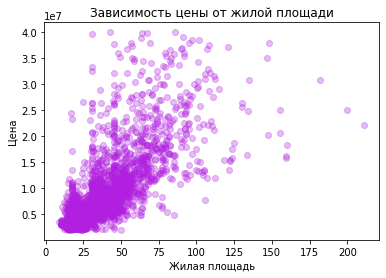

In [42]:
sc_table(piv_price, 'living_area', '#b11fe0', 'Зависимость цены от жилой площади', 'Жилая площадь', 'Цена')

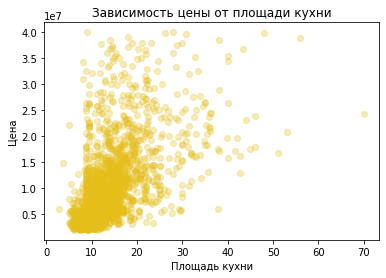

In [43]:
sc_table(piv_price, 'kitchen_area', '#e6be19', 'Зависимость цены от площади кухни', 'Площадь кухни', 'Цена')

In [44]:
print('Коэффициент Пирсона общей площади:', data['last_price'].corr(data['total_area']))
print('Коэффициент Пирсона жилой площади:', data['last_price'].corr(data['living_area']))
print('Коэффициент Пирсона площади кухни:', data['last_price'].corr(data['kitchen_area']))

Коэффициент Пирсона общей площади: 0.7856695117018931
Коэффициент Пирсона жилой площади: 0.6619447520454302
Коэффициент Пирсона площади кухни: 0.5664297686339221


есть ли зависимость цены от площадей? да, это видно и по графикам и по коэффиценту Пирсона (больше всего зависимость от общей площади), чем выше любая площадь (жилая, кухни или общая), тем будет выше цена квартиры, конечно, не стоит забывать, что на цену влияет и расположение/парки и т.д., поэтому, к примеру, есть квартира с общей площадью 150 км и ценой 7-8 миллионов.

##### Зависимость от дней, месяцев u годов

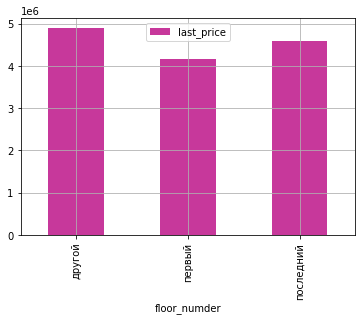

In [45]:
day_price = round(data.pivot_table(index=['floor_numder'], values='last_price', aggfunc='median')).astype('int64')

day_price.plot.bar(grid=True, color='#c7389b');

если прослеживать по медианнам, то самый дешевые квартиры на первом этаже, а самый дорогие на других, зависимость присутствует

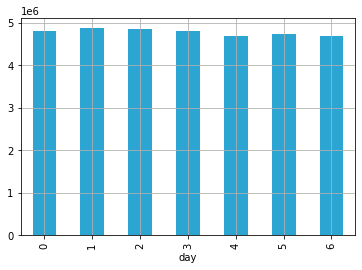

In [46]:
day_price = round(data.pivot_table(index=['day'], values='last_price', aggfunc='median')).astype('int64')
day_price.plot.bar(grid=True, color='#2da5d2', legend=False);

в воскресенье публикуются меньше всего дорогих квартир, во вторник самые дорогие

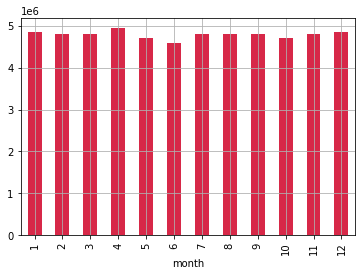

In [47]:
day_price = round(data.pivot_table(index=['month'], values='last_price', aggfunc='median')).astype('int64')
day_price.plot.bar(grid=True, color='#d72848', legend=False);

дороже всего квартиры, продающиеся с апреля, дешевле всего - с июня

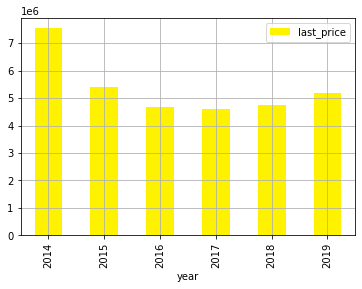

In [48]:
day_price = round(data.pivot_table(index=['year'], values='last_price', aggfunc='median')).astype('int64')
day_price.plot.bar(grid=True, color='#fff200');

наблюдается спад стоимости квартир с 2014 вплоть до 2017 и далее идёт рост

##### Зависимость от количества комнат

зависимость от числа комнат явно есть. начиная с пяти комнат уже видно как начинают преобладать дорогие квартиры, а в квартирах с одной и двумя комнатами преобладает цена от 2 млн до 15 млн

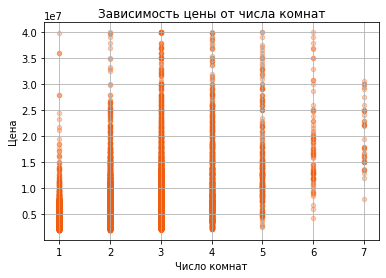

In [49]:
data.plot(x = 'rooms', y = 'last_price', kind='scatter', grid=True, alpha=0.3, color='#ef5d10')
plt.title('Зависимость цены от числа комнат')
plt.xlabel('Число комнат')
plt.ylabel('Цена');

#### 10 населённых пунктов с наибольшим числом объявлений

самый дорогой квадратный метр в Санкт-Петербурге почти 115 тысяч, да и по обвъявлениям этот город лидирующий целых 15 тысяч

а вот самый дешевый квадртаный метр в село Шум всего 34 тысячи и одно объявление(

но если судить по топ 10, то самый дешевый квадратный метр в Выборге 58 тысяч, что в два раза меньше Санкт-Петербурга, а объявлений всего 237, всего-то в 66 раз меньше

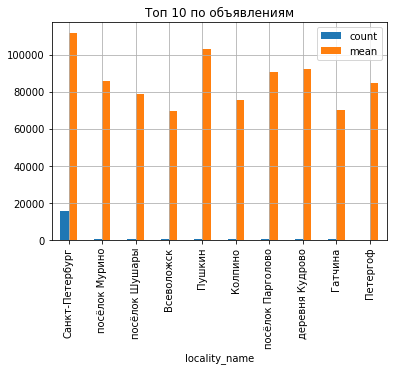

In [50]:
name_table = data.groupby('locality_name')['one_metr'].agg(['count', 'mean'])# count-кол-во объявлений, mean-цена одного кв.м
name_table.sort_values(by='count', ascending=False).head(10).plot(kind='bar', title='Топ 10 по объявлениям', grid=True);

#### Средняя цена каждого километра в Санкт-Петербурге

чем дальше квартира от центра, тем она дешевле

центр заканчивается на 7-10 км

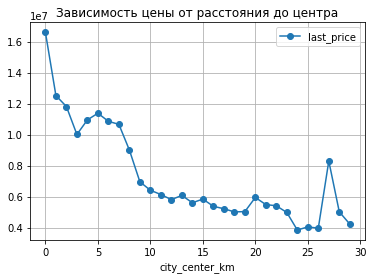

In [51]:
cb_top = data[data['locality_name']=='Санкт-Петербург'].groupby('city_center_km')['last_price'].agg('mean')
cb_top.plot(title='Зависимость цены от расстояния до центра', grid=True, legend=True, style='o-');

### Общий вывод

Избавили датафрейм от большего количества пропусков, которые скорее всего произошли либо из-за невнимательности, либо по вине неверной выгрузки, также избавились от аномалий и неявных дубликатов.

Создали новые столбци со информацией о цене одного квадратного метра, дне недели, месяце и годе публикации, типе этажа квартиры и расстояние до центра города в км.

- Провели анализ нескольких параметров и выяснили:
    1. квартир с общей площадью примерно 50 больше всего на рынке
    2. квартиры с жилой площадью 25-30 преобладают на рынке
    3. кухни площадью 8-10 явно встречаются во многих квартирах
    4. чаще всего продаются квартиры с ценником от 3.5 до 5 миллионов
    5. однушки являются самыми часто встречаемыми
    6. квартиры с потолками где-то 2,5 метров преобладают на рынке
    7. первый этаж самый частый
    8. преобладает тип этажей "другие"
    9. квартиры в домиках с 5-6 этажами чаще всего появляются в объявлениях
    10. чаще всего квартиры находят от центра в 12-13 км
    11. до аэропорта придётся ехать чаще всего от 21 км
    12. многие квартиры находятся рядом с парком в пределах 500 метров
    13. чаще всего объявление выкладывают в четверг, а вот реже всего в воскресенье, рост объявлений приходится на январь, а самый большой спад в мае
    

- Изучили как быстро продавались квартиры:
    1. то, что находится в диапазоне от медианы (95 дней) до среднего (181 день), можно считать достаточно быстрыми продажами
    2. а всё что больше 400 уже долгие продажи
    
    
- Изучили какие факторы больше всего влияют на полную стоимость объекта:
    1. самый влиятельный фактор это общая площадь, а сымй невлиятельный дни
    2. на цену также оказывают влияние количество комнат (а они оказывают влияние на саму общую площадь), тип этажа, площадь жилая и площадь кухни
    3. в воскресенье публикуются меньше всего дорогих квартир, во вторник самые дорогие
    4. дороже всего квартиры, продающиеся с апреля, дешевле всего - с июня
    5. наблюдается спад стоимости квартир с 2014 вплоть до 2017 и далее идёт рост


- Нашли 10 населенных пунктов с самым большим количеством объявлений и почситали в них цену одного кв.м:
    1. самый дорогой квадратный метр в Санкт-Петербурге почти 115 тысяч, да и по обвъявлениям этот город лидирующий целых 15 тысяч
    2. самый дешевый квадратный метр в Выборге 58 тысяч, что в два раза меньше Санкт-Петербурга, а объявлений всего 237, всего-то в 66 раз меньше
    
    
- Изучили как отдаленность от центра (Санкт-Петербурга) влияет на цену одного кв.м:
    1. чем дальше квартира находится от центра, тем дешевле стоимость её кв.м
    
    
Подводя итоги, можно сказать, что очень многие факторы влияют на цену объекта, от метража до типа этажа. Самой бюджетной можно назвать квартиру находящиюся в 7 км от центра, можно и дальше, на первом этаже, от одной до трёх комнат и до 65 кв.м, но если хочется по-дороже то можно просто смотреть в пределах 7 км от ценрта